In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from textblob import TextBlob

In [73]:

dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

# all_users = pd.read_csv('../data/all_users.csv')
# users_activities = pd.read_csv('../data/users_activity.csv')
# sample_tweets = pd.read_csv('../data/sample_tweets.csv')

users = pd.read_csv("../data/all_users.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})
tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
                     # nrows = 400000,
                     parse_dates=['created_at'],
                     converters={"user_id": str,
                                 "tweet_id": str},
                     date_parser=dateparse,
                     lineterminator='\n')
activity = pd.read_csv("../data/users_activity.csv", #path/to/activity_file/
                       converters={"user_id": str})

core_users_ids = pd.read_csv("../data/core_users.csv",
                             converters={"user_id": str})


# Filtra il dataframe per includere solo le righe in cui l'user_id è presente nella lista dei core users
core_users = users[users["user_id"].isin(core_users_ids["user_id"])]


C:\Users\davis\AppData\Local\Temp\ipykernel_11660\3229685572.py:7: DtypeWarning: Columns (2,3,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv("../data/all_users.csv",
C:\Users\davis\AppData\Local\Temp\ipykernel_11660\3229685572.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file


In [74]:
core_users_copy = core_users.copy()

core_users.head()
# activity.head()
# tweets.head()

,user_id,created_at,user_screen_name,name,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,location,description,nbr_accounts,nbr_usernames
11102,841318992094605313,2017-03-13 16:04:13+00:00,dg080310,Donato G.🇮🇹#ICEUTNE#,210.0,486.0,49.0,0.0,3.0,False,False,NaN,Monza Lombardia 🏎 ...,1.0,2.0
22702,1218242063638188033,2020-01-17 18:42:36+00:00,Fidelio16852684,Fidelio,0.0,0.0,97.0,0.0,8.0,False,False,NaN,NaN,1.0,1.0
36236,1311952044144685056,2020-10-02 08:52:58+00:00,IlS0vran,ilS0vranIsta,36.0,35.0,1.0,1.0,17.0,False,False,NaN,NaN,1.0,1.0
43382,52021947,2009-06-29 10:46:16+00:00,marcobobabo,Marco D'Addabbo,10.0,167.0,368.0,0.0,24.0,False,False,"Milano, Lombardia",puglioemilianmilanestesista. il dottor house è...,1.0,1.0
64474,1298360422433730560,2020-08-25 20:43:52+00:00,Sararisso3,APOCALYPTO. IL SONNO DELLA RAGIONE GENERA MOSTRI.,46.0,25.0,0.0,0.0,52.0,False,False,NaN,"Raga, bro, con la 3° guerra mondiale possiamo ...",1.0,1.0


## Credibility

### Number of followers

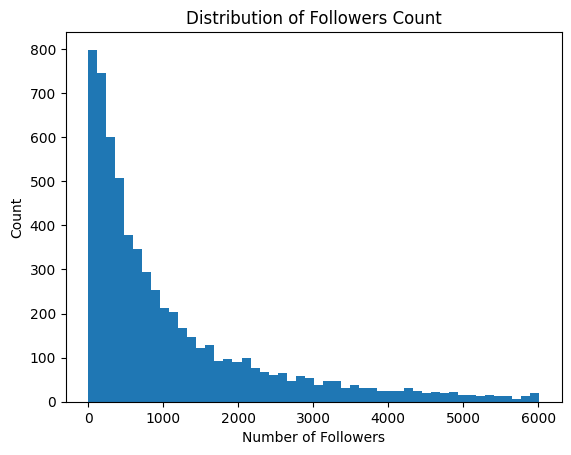

In [75]:
#core_users_copy['log_followers'] = np.log10(core_users_copy['nbr_followers'] + 1)

plt.hist(core_users['nbr_followers'], bins=50, range=(0, core_users['nbr_followers'].quantile(0.90)))
plt.xlabel('Number of Followers')
plt.ylabel('Count')
plt.title('Distribution of Followers Count')
plt.show()

### Number of followings

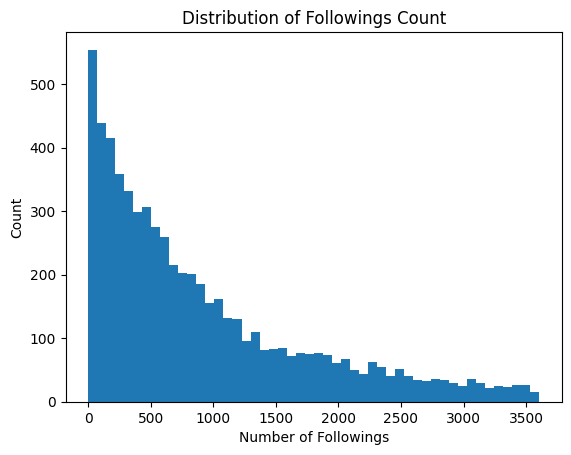

In [76]:
plt.hist(core_users['nbr_followings'], bins=50, range=(0, core_users['nbr_followings'].quantile(0.90)))
plt.xlabel('Number of Followings')
plt.ylabel('Count')
plt.title('Distribution of Followings Count')
plt.show()

### Favorites Ratio

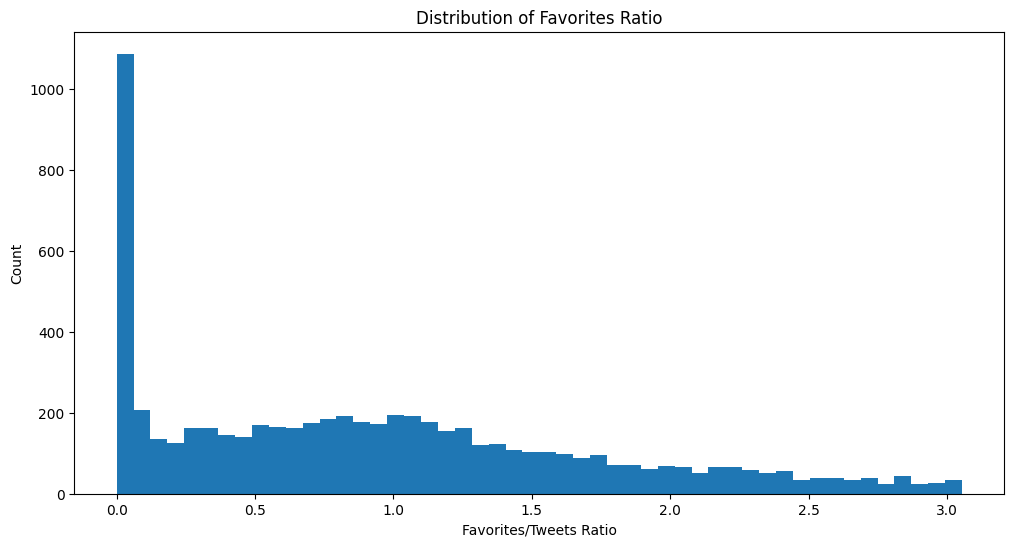

In [77]:
core_users_copy['favorites_ratio'] = core_users_copy['nbr_liked_tweets'] / core_users_copy['nbr_tweets'].replace(0, np.nan)

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['favorites_ratio'].dropna(), bins=50, range=(0, core_users_copy['favorites_ratio'].quantile(0.90)))
plt.xlabel('Favorites/Tweets Ratio')
plt.ylabel('Count')
plt.title('Distribution of Favorites Ratio')
plt.show()

### Followers Ratio

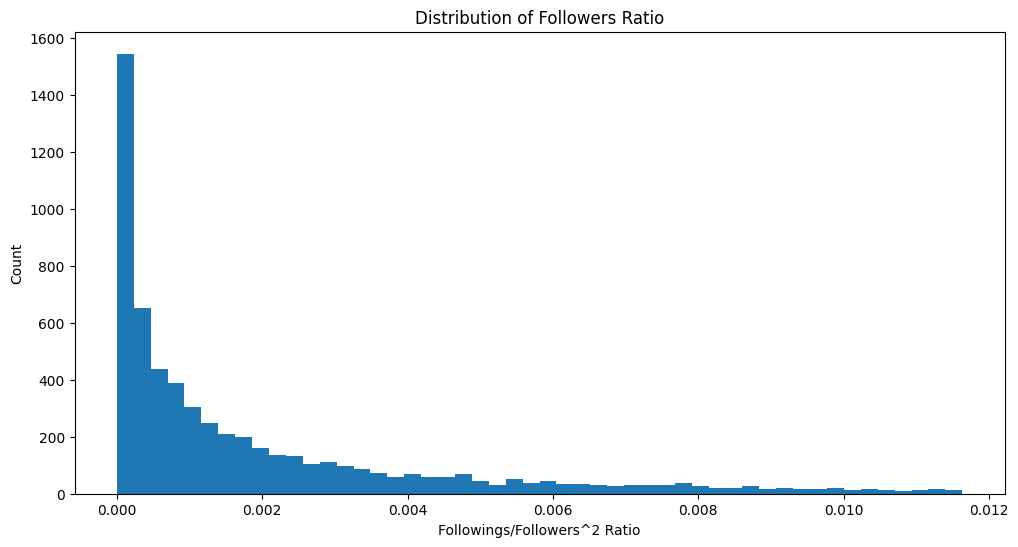

In [78]:
core_users_copy['followers_ratio'] = core_users_copy['nbr_followings'] / (core_users_copy['nbr_followers']**2 + 1)

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['followers_ratio'].dropna(), bins=50, range=(0, core_users_copy['followers_ratio'].quantile(0.85)))
plt.xlabel('Followings/Followers^2 Ratio')
plt.ylabel('Count')
plt.title('Distribution of Followers Ratio')
plt.show()


### Following Ratio

C:\Users\davis\AppData\Local\Temp\ipykernel_11660\4097326704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_users['created_at'] = pd.to_datetime(core_users['created_at'])


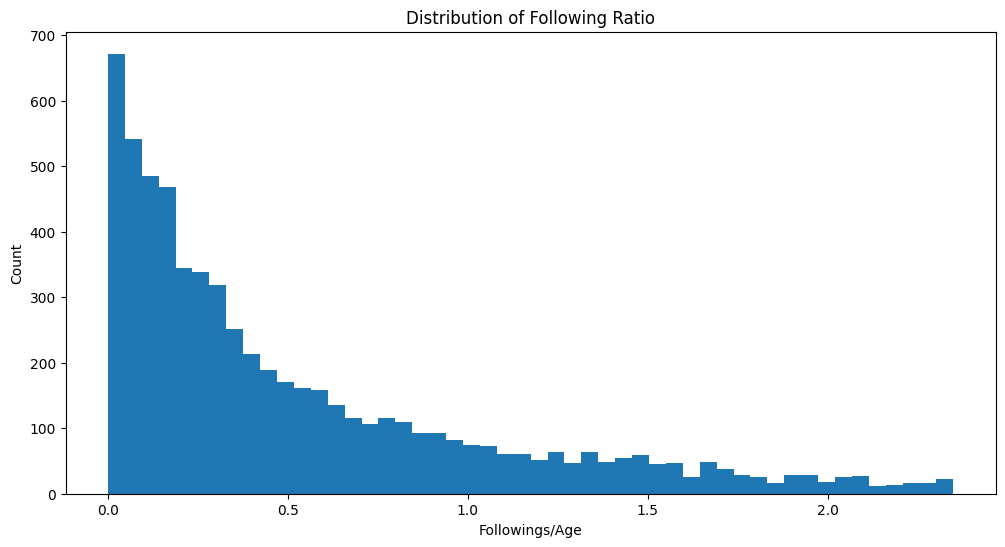

In [79]:
core_users['created_at'] = pd.to_datetime(core_users['created_at'])

# Tweet più recente
current_date = tweets['created_at'].max()

# Controllo che siano tutti tz-naive o tz-aware
# core_users_credibility['created_at'] = pd.to_datetime(core_users_credibility['created_at']).dt.tz_localize(None)
# current_date = current_date.tz_localize(None)

core_users_copy['age'] = (current_date - core_users['created_at']).dt.days
core_users_copy['following_ratio'] = core_users_copy['nbr_followings'] / (core_users_copy['age'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['following_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_copy['following_ratio'].quantile(0.90)))
plt.xlabel('Followings/Age')
plt.ylabel('Count')
plt.title('Distribution of Following Ratio')
plt.show()


### Tweet Ratio

C:\Users\davis\AppData\Local\Temp\ipykernel_11660\217331312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_users['created_at'] = pd.to_datetime(core_users['created_at'])


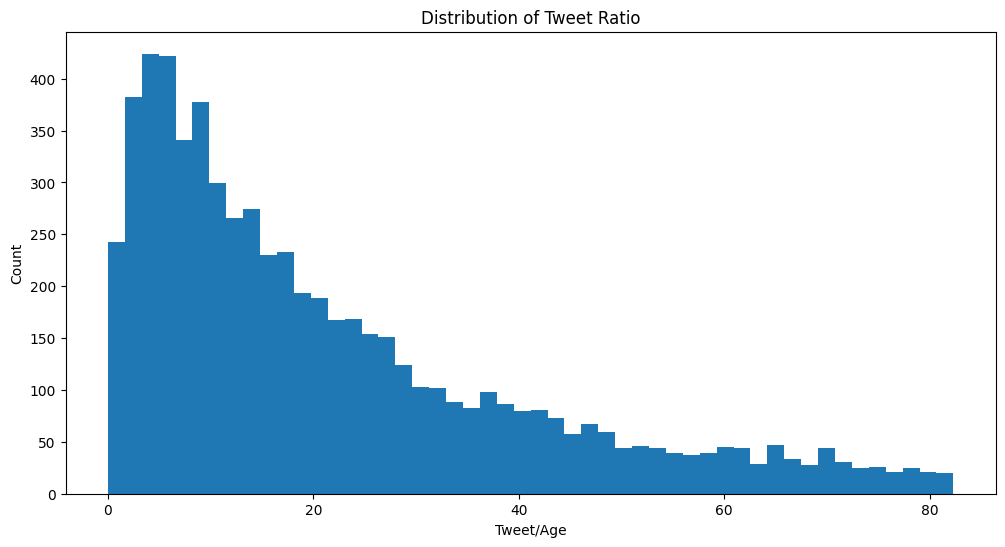

In [80]:
core_users['created_at'] = pd.to_datetime(core_users['created_at'])

# Tweet più recente
current_date = tweets['created_at'].max()

# Controllo che siano tutti tz-naive o tz-aware
# core_users_credibility['created_at'] = pd.to_datetime(core_users_credibility['created_at']).dt.tz_localize(None)
# current_date = current_date.tz_localize(None)

core_users_copy['age'] = (current_date - core_users['created_at']).dt.days
core_users_copy['tweet_ratio'] = core_users_copy['nbr_tweets'] / (core_users_copy['age'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['tweet_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_copy['tweet_ratio'].quantile(0.90)))
plt.xlabel('Tweet/Age')
plt.ylabel('Count')
plt.title('Distribution of Tweet Ratio')
plt.show()


## Initiative

### Retweet Ratio

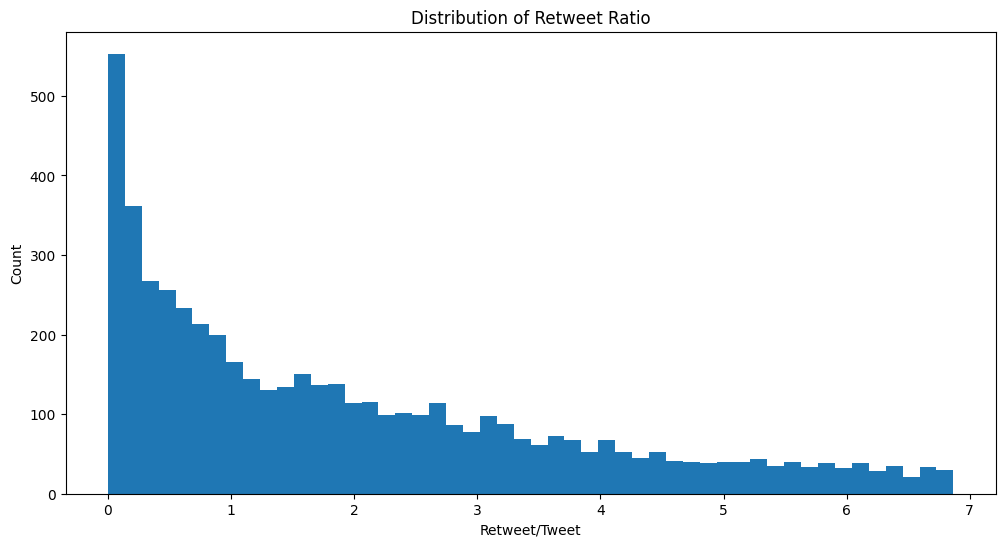

In [81]:
# Numero di retweets effettuato da ogni utente

# Filtra i tweet da core_user
core_users_tweets = tweets[tweets['user_id'].isin(core_users_copy['user_id'])]

# Calcola il numero di retweets per ogni utente
retweets_count = core_users_tweets[core_users_tweets['is_retweet'] == 1]['user_id'].value_counts()

# Calcola il numero di tweets originali per ogni utente
original_tweets_count = core_users_tweets[core_users_tweets['is_retweet'] == 0]['user_id'].value_counts()


# Trasformazione retweets_count e original_tweets_count in un DataFrame
retweets_count_df = retweets_count.reset_index()
original_tweets_count_df = original_tweets_count.reset_index()

# Rinomina delle colonne
retweets_count_df.columns = ['user_id', 'retweets_count']
original_tweets_count_df.columns = ['user_id', 'nbr_original_tweets']

# Unione retweets_count_df con original_tweets_count_df
user_tweets_df = pd.merge(retweets_count_df, original_tweets_count_df, on='user_id', how='outer')
# Unione user_tweets_df con core_users
core_users_copy = pd.merge(core_users_copy, user_tweets_df, on='user_id', how='left')


core_users_copy['retweet_ratio'] = core_users_copy['retweets_count'] / (core_users_copy['nbr_original_tweets'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['retweet_ratio'].dropna(), bins=50, range=(0, core_users_copy['retweet_ratio'].quantile(0.85)))
plt.xlabel('Retweet/Tweet')
plt.ylabel('Count')
plt.title('Distribution of Retweet Ratio')
plt.show()


### Reply Ratio

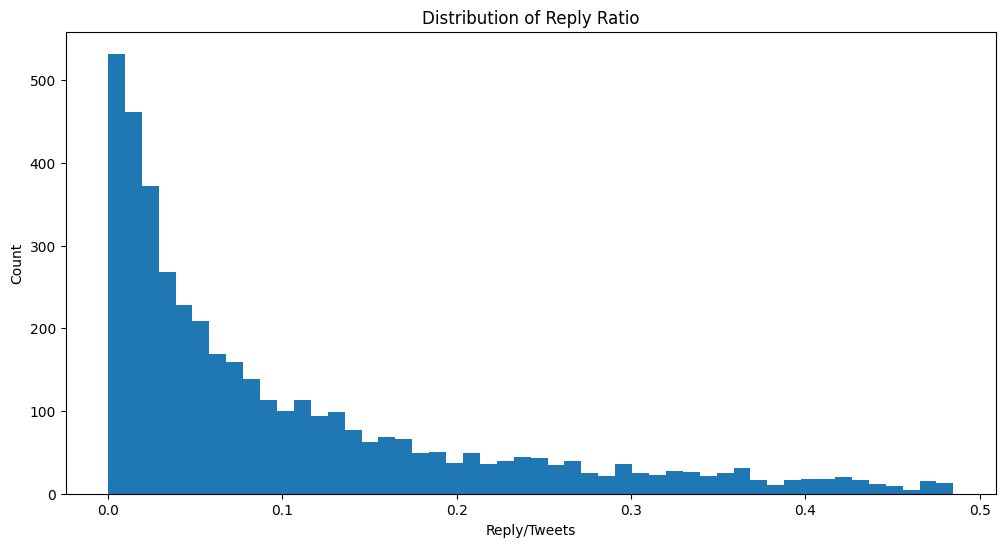

In [82]:
# Numero di risposte effettuate da ogni core_users

# Filtra i tweet da core_user
core_users_tweets = tweets[tweets['user_id'].isin(core_users_copy['user_id'])]

# Calcola il numero di retweets per ogni utente
replies_count = core_users_tweets[core_users_tweets['is_reply'] == 1]['user_id'].value_counts()

# Calcola il numero di tweets originali per ogni utente
no_replies_count = core_users_tweets[core_users_tweets['is_reply'] == 0]['user_id'].value_counts()


# Trasformazione replies_count e no_replies_count in un DataFrame
replies_count_df = replies_count.reset_index()
no_replies_count_df = no_replies_count.reset_index()
# Rinomina delle colonne
replies_count_df.columns = ['user_id', 'reply_count']
no_replies_count_df.columns = ['user_id', 'no_reply_tweets']
# Unione replies_count_df con no_replies_count_df
user_tweets_df = pd.merge(replies_count_df, no_replies_count_df, on='user_id', how='outer')
# Unione user_tweets_df con core_users
core_users_copy = pd.merge(core_users_copy, user_tweets_df, on='user_id', how='left')


core_users_copy['retweet_ratio'] = core_users_copy['reply_count'] / (core_users_copy['no_reply_tweets'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_copy['retweet_ratio'].dropna(), bins=50, range=(0, core_users_copy['retweet_ratio'].quantile(0.85)))
plt.xlabel('Reply/Tweets')
plt.ylabel('Count')
plt.title('Distribution of Reply Ratio')
plt.show()


## Adaptability

### Time between tweets

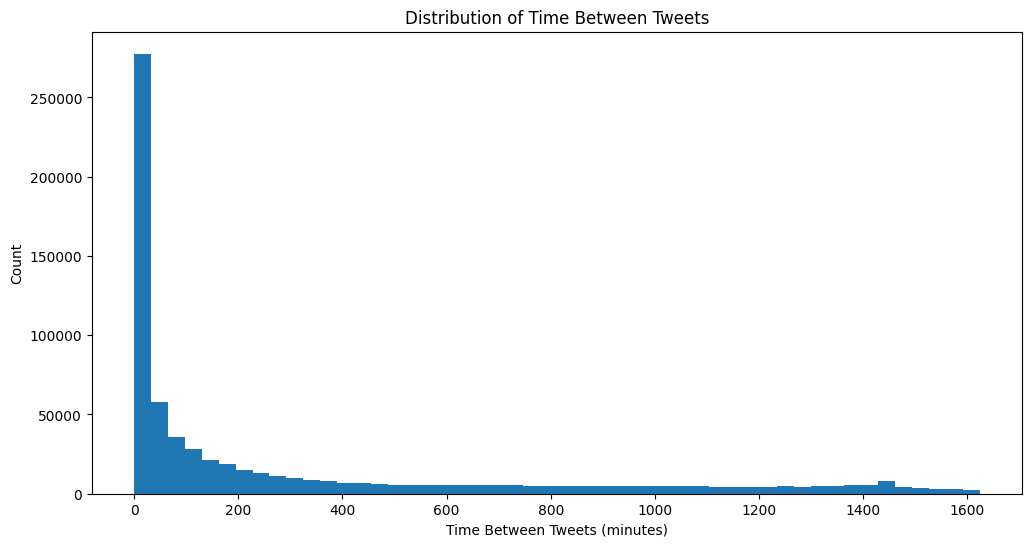

In [83]:
# Filtraggio solo i tweet da core_users e non retweet
core_users_tweets = tweets[(tweets['user_id'].isin(core_users['user_id'])) & (tweets['is_retweet'] == 0)]

# Ordine tweet per core_users e data di creazione
core_users_tweets_sorted = core_users_tweets.sort_values(by=['user_id', 'created_at'])

# Calcolo della differenza di tempo tra tweet consecutivi per ogni core_users
core_users_tweets_sorted['time_between_tweets'] = core_users_tweets_sorted.groupby('user_id')['created_at'].diff()

# Conversione della differenza di tempo in minuti
core_users_tweets_sorted['time_between_tweets'] = core_users_tweets_sorted['time_between_tweets'].dt.total_seconds() / 60


plt.figure(figsize=(12, 6))

plt.hist(core_users_tweets_sorted['time_between_tweets'].dropna(), bins=50, range=(0, core_users_tweets_sorted['time_between_tweets'].quantile(0.85)))
plt.xlabel('Time Between Tweets (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Time Between Tweets')
plt.show()


### Time between retweets

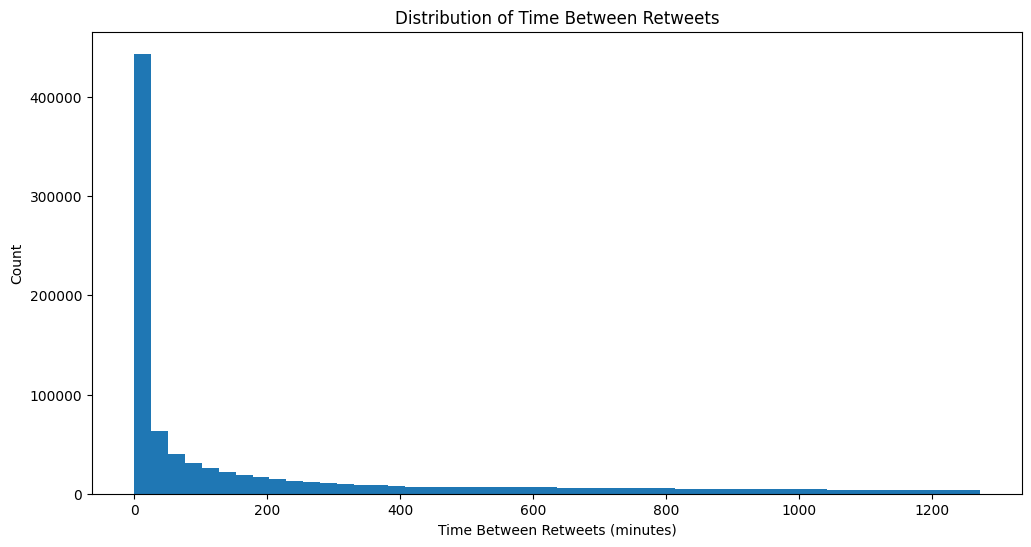

In [84]:
# Filtraggio solo i tweet da core_users e non retweet
core_users_retweets = tweets[(tweets['user_id'].isin(core_users['user_id'])) & (tweets['is_retweet'] == 1)]

# Ordine tweet per core_users e data di creazione
core_users_retweets_sorted = core_users_retweets.sort_values(by=['user_id', 'created_at'])

# Calcolo della differenza di tempo tra tweet consecutivi per ogni core_users
core_users_retweets_sorted['time_between_tweets'] = core_users_retweets_sorted.groupby('user_id')['created_at'].diff()

# Conversione della differenza di tempo in minuti
core_users_retweets_sorted['time_between_tweets'] = core_users_retweets_sorted['time_between_tweets'].dt.total_seconds() / 60


plt.figure(figsize=(12, 6))

plt.hist(core_users_retweets_sorted['time_between_tweets'].dropna(), bins=50, range=(0, core_users_retweets_sorted['time_between_tweets'].quantile(0.85)))
plt.xlabel('Time Between Retweets (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Time Between Retweets')
plt.show()


## Clustering

C:\Users\davis\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


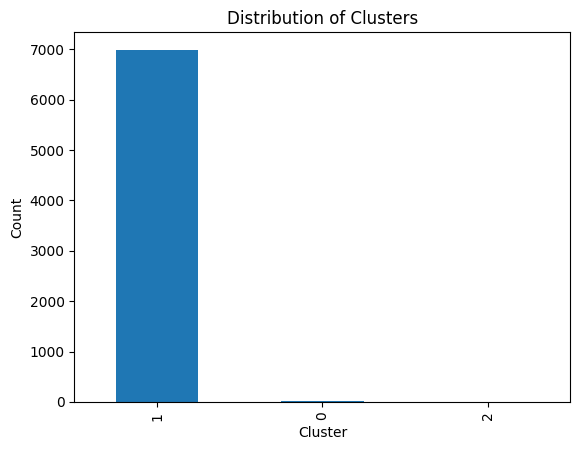

In [85]:
# Seleziona le caratteristiche da utilizzare per il clustering
features = ['nbr_followers', 'nbr_tweets', 'following_ratio', 'favorites_ratio', 'tweet_ratio']

# Normalizza le caratteristiche
core_users_normalized = (core_users_copy[features] - core_users_copy[features].mean()) / core_users_copy[features].std()

# Sostituisci i valori mancanti con 0
core_users_normalized = core_users_normalized.fillna(0)

# Esegui il clustering K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(core_users_normalized)

# Aggiungi le etichette dei cluster ai dati
core_users_copy['cluster'] = kmeans.labels_

# Visualizza la distribuzione dei cluster
core_users_copy['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()


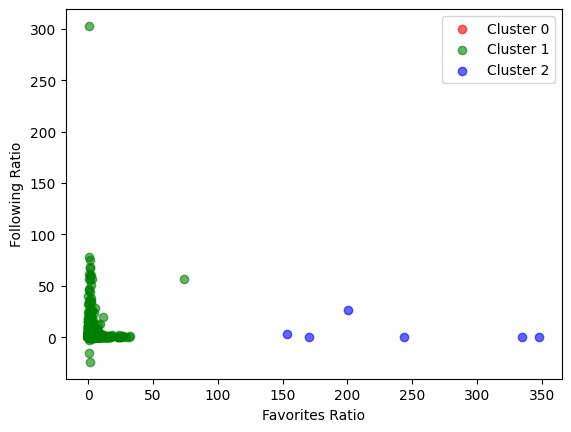

In [86]:
# Assegna ad ogni cluster un colore
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots()

# Crea uno scatter plot per ogni cluster
for i in range(len(core_users_copy['cluster'].unique())):
    cluster_data = core_users_copy[core_users_copy['cluster'] == i]
    ax.scatter(cluster_data['favorites_ratio'], cluster_data['following_ratio'], c=colors[i], label=f'Cluster {i}', alpha=0.6)

ax.set_xlabel('Favorites Ratio')
ax.set_ylabel('Following Ratio')
ax.legend()

plt.show()
